# Simulations

The following Jupiter notebook contains simulations which compare the actual rate of adoption of #BlackLivesMatter to models of simple contagion, complex contagion, and a null model that I developed for my research ( what we would've expected to happen in the absence of online social contagion ).

In [2]:
from sqlitedict import SqliteDict
import pandas as pd
import geopandas as gpd
from pyarrow import feather
import matplotlib.pyplot as plt
import math
import autograd.numpy as np
from autograd import grad 
import itertools

from utils.common import constants as c
from utils.data_analysis.load_edges import load_edges_df, load_geo_edges_df
from utils.data_analysis.load_users import load_users_dfs
from utils.data_analysis.load_tweets import load_tweets_dfs

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Path to Utils: /Volumes/rc/lab/S/SIGIL/crist/utils


## Load in Required Data

* `geo_users_w_info_gdf` contains the relevant informtion about users with geotags who adopted (our study sample)
* `adopters_df` has the adoption_time of each user which we need, as well as the list of actual neighbor adopters.'
* `news_df` has the number of news articles containing hashtag by day. We use this to estimate amount of outside influence per day.

If any of the above data frames have not yet been loaded and saved as feathers, this will fail.

In [3]:
colors = {0:'black', 1:'violet', 2:'orange', 3:'lightseagreen', 4:'red', 5:'blue'}
markers = {0:'X', 1:'s', 2:'D', 3:'v', 4:'^', 5:'<'}
labels = {0:'Rur.White', 1:'Sub.Blacker', 2:'Sub.Richer', 3:'BigCities', 4:'SubRur.Poorer', 5:'MidCities'}

In [4]:
news_df = pd.read_csv("utils/data_analysis/datasets/NewsData.csv")
news_df["Date"] = pd.to_datetime(news_df["Date"])
news_df["Days_Since"] = news_df.index
news_df

,Date,Articles,Days_Since
0,2020-05-25,13,0
1,2020-05-26,94,1
2,2020-05-27,288,2
3,2020-05-28,348,3
4,2020-05-29,559,4
5,2020-05-30,626,5
6,2020-05-31,1087,6
7,2020-06-01,2181,7
8,2020-06-02,3180,8


In [5]:
adopters_df = feather.read_feather("utils/data_analysis/feathers/adopters_df.ftr")
adopters_df = adopters_df.set_index("index")   # feather doesn't support non-default indices, must be re-set on load.
adopters_df['adopted_time'] = adopters_df['adopted_time'].dt.tz_convert('US/Eastern')
adopters_df.dtypes

adopted_time         datetime64[ns, US/Eastern]
exposures                               float64
Nbr Adopters                             object
Nbr Adopter Count                         int64
dtype: object

In [6]:
geo_users_w_info_gdf = gpd.read_feather("utils/data_analysis/feathers/geo_users_w_info_gdf.ftr")
geo_users_w_info_gdf = geo_users_w_info_gdf.merge(
    adopters_df, how="left", left_on="U_ID", right_index=True
)
geo_users_w_info_gdf.fillna({"Nbr Adopter Count": 0, "exposures": 0}, inplace=True)
geo_users_w_info_gdf.dtypes
geo_users_w_info_gdf.describe()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std,cluster_label,exposures,Nbr Adopter Count
count,3.437900e+04,3.437900e+04,34379.000000,3.437900e+04,34300.000000,34300.000000,3.437900e+04,34379.000000,3.437900e+04,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34050.000000,34194.000000,34379.000000,34379.000000,34300.000000,34050.000000,34379.000000,3.437900e+04,3.437900e+04,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000
mean,1.579819e+03,2.598706e+09,25.902382,8.556566e+05,8036.880040,192.025560,4.641589e+05,156743.689229,2.347540e+05,61.736517,18.027244,20.236247,23.307587,45324.986096,26451.629134,22605.882348,37659.224439,25.720033,0.160133,0.630862,1196.417231,3.282625e+03,1.658021e+04,0.680125,0.770593,-0.538963,0.341629,0.542345,0.036051,2.859624,288.139009,99.726199
std,3.955855e+03,1.652377e+09,16.489786,9.993318e+05,13604.529302,466.710048,5.485587e+05,221619.030296,3.245024e+05,18.226162,16.546325,13.338321,18.519561,18702.669909,9201.380373,8103.623555,13530.812948,36.069957,0.161441,0.235241,4387.541000,5.706542e+04,3.645231e+04,1.949278,1.363909,0.919040,1.058868,1.318129,0.796388,1.589941,1234.590579,338.309230
min,0.000000e+00,1.001926e+08,1.000000,1.660000e+02,0.434984,0.032625,1.630000e+02,0.000000,0.000000e+00,1.380000,0.000000,0.000000,0.000000,4226.000000,602.000000,1611.000000,4725.000000,0.000000,0.000000,0.020028,0.000000,0.000000e+00,1.000000e+00,-0.470243,-0.579824,-3.582392,-0.812009,-2.354235,-2.211264,0.000000,0.000000,-1.000000
25%,0.000000e+00,9.001336e+08,9.000000,8.099300e+04,1933.357000,36.339705,5.553000e+04,6863.500000,9.244500e+03,47.780000,5.780000,9.550000,8.210000,33715.000000,20324.000000,18142.000000,29147.000000,1.000000,0.023944,0.498853,290.000000,1.900000e+02,2.039000e+03,-0.193044,-0.380999,-1.242709,-0.442123,-0.275905,-0.490059,2.000000,29.000000,15.000000
50%,2.328306e-10,2.605938e+09,26.000000,3.957770e+05,3570.421000,87.658840,2.094240e+05,45888.000000,6.624500e+04,60.300000,11.880000,17.200000,18.750000,41883.000000,25557.000000,20597.000000,35563.000000,10.000000,0.107292,0.611203,597.000000,4.600000e+02,6.379000e+03,0.041726,0.326842,-0.611399,-0.051758,0.299761,-0.035321,3.000000,90.000000,41.000000
75%,9.275834e+02,3.906102e+09,39.000000,1.579075e+06,9067.710000,235.938329,7.563910e+05,240993.000000,4.233490e+05,76.380000,28.280000,28.450000,33.035000,49305.000000,30095.000000,26033.000000,41569.000000,34.000000,0.272115,0.726091,1227.000000,1.169000e+03,1.745500e+04,0.830088,1.719667,0.199423,0.997745,0.822849,0.353585,4.000000,247.000000,100.000000
max,2.993679e+04,7.214985e+09,72.000000,3.433961e+06,71488.690000,24607.898341,2.556502e+06,833683.000000,1.050342e+06,100.000000,94.340000,98.430000,100.000000,156737.000000,192355.000000,238039.000000,164307.000000,204.000000,2.579073,5.684942,362676.000000,6.848484e+06,2.355436e+06,9.781831,21.214474,1.390442,5.225198,8.394457,14.464471,5.000000,75224.000000,24656.000000


## Plot the growth over time

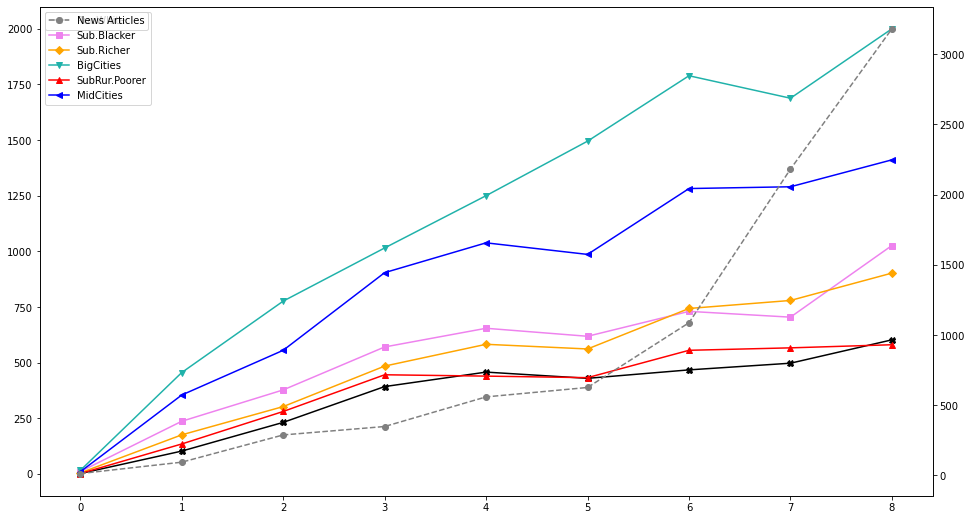

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(16,9))

clusters = geo_users_w_info_gdf.groupby("cluster_label")

for label, cluster in clusters:
    
    day_counts = cluster.groupby(
        pd.Grouper(key="adopted_time", freq='24h')
    ).agg({
        "U_ID": "count"
    })
    day_counts.reset_index(inplace=True)
    ax.plot(
        day_counts.index,
        day_counts["U_ID"],
        color = colors[label],
        label = labels[label],
        marker = markers[label]
    )
    
ax2 = ax.twinx()
ax2.plot(
    news_df.index, 
    news_df["Articles"], 
    color="grey", 
    linestyle="dashed",
    label="News Articles",
    marker="o"
)

ax.legend()
ax2.legend()

## Generate Activity Dataframe

For users whose activity-rate is downloaded, there are 720 periods -- 30 days (default) at 1 hour granularity.

In [7]:
def get_logins(activity_rt):
    '''
    Each period in which twt.count > 0 represents a log-in.
    '''
    return np.count_nonzero(activity_rt)

TOTAL_TIME_STEPS = 720 # 30 days at 1 hr granularity (period in which I checked if a user had tweeted w/in)

In [8]:
def load_activites_df():
    
    try:
        activity_df = feather.read_feather("utils/data_analysis/feathers/activity_df.ftr")
    except Exception as e:
        print("Couldn't find feathered version of activites_df. Generating now.")
        
        dSeries = []
        count = 0

        with SqliteDict(c.USERS_SQL) as u_dict:

            print(u_dict)
            for _, user in u_dict.items():
                if hasattr(user, "activity_rate") and len(user.geos) > 0:
                    dSeries.append((user.user_id, user.activity_rate))

            # Sometimes SQLiteDict gets stuck.
            u_dict.close(force=True)
            
        activity_df = pd.DataFrame.from_dict(dSeries)
        activity_df.columns =[c.U_ID, "Activity Rate"]
        activity_df["Activity Rate"] = activity_df["Activity Rate"].apply(get_logins)
        activity_df["Activity Rate"] = activity_df["Activity Rate"].div(TOTAL_TIME_STEPS)

        activity_df.to_feather("utils/data_analysis/activity_df.ftr")
        
    return activity_df

In [9]:
activity_df = load_activites_df()
activity_df.describe()

,Activity Rate
count,70383.000000
mean,0.103414
std,0.117661
min,0.000000
25%,0.020833
50%,0.058333
75%,0.144444
max,0.998611


#### View Activity Rates:

,Activity Rate,U_ID
count,522.000000,522.000000
mean,0.366837,134.833333
std,0.219958,245.150917
min,0.000000,1.000000
25%,0.180903,9.000000
50%,0.361806,39.500000
75%,0.542708,133.750000
max,0.998611,2406.000000


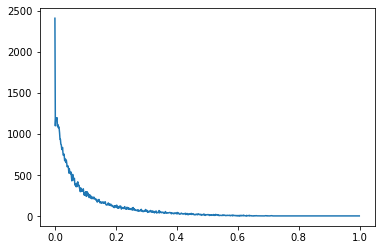

In [15]:
fig, ax = plt.subplots(1,1)
activity_counts = activity_df.groupby("Activity Rate").count() # / 720
activity_counts.reset_index(inplace=True)

plt.plot(
    activity_counts["Activity Rate"], 
    activity_counts["U_ID"]
)

activity_counts.describe()

## Construct Exposures by Hour DF

In [16]:
tweets_df, _ = load_tweets_dfs()

In [17]:
start_time = pd.Timestamp('2020-05-25 04:00:00+00:00', tz='US/Eastern') # the timestamp must be in UTC time, then converted.
tweets_df[c.CREATED_AT] = tweets_df[c.CREATED_AT].dt.ceil('h')
tweets_df[c.CREATED_AT] = tweets_df[c.CREATED_AT] - start_time
tweets_df[c.CREATED_AT] = tweets_df[c.CREATED_AT] / pd.Timedelta(1, "h")
tweets_df[c.CREATED_AT]

0             1.0
1             1.0
2             1.0
3             1.0
4             1.0
            ...  
18004744    212.0
18004745    212.0
18004746    212.0
18004747    212.0
18004748    212.0
Name: Timestamp, Length: 18004749, dtype: float64

In [18]:
tweets_grpd = tweets_df.groupby([c.CREATED_AT])
periods = range(len(tweets_grpd)+1) # +1 because we have to account for the 0th hour

In [19]:
def load_edges_dict():
    '''
    Generates a dictionary where each key is an adopter (geotagged or not) 
    who is followed by a geotagged adopter, and each item is a set of people who follow them 
    (geotagged adopters)
    '''
    
    edges_df = load_edges_df()
    edges_df = edges_df.drop(["Type", "Weight"], axis=1)
    edges_df = edges_df.set_index('Source')
    edges_df = edges_df.groupby("Source").agg({
        "Target": lambda x: set(x)
    })
    
    edges_dict = edges_df.to_dict(orient='index')
    return edges_dict

edges_dict = load_edges_dict()
len(edges_dict)

26931489

In [10]:
def load_exposures_by_pd_df():
    
    try:
        exposures_by_pd_df = feather.read_feather("utils/data_analysis/feathers/exposures_by_pd_df.ftr")
    except Exception as e:
        print("Couldn't find exposures_by_pd_df feather. Generating raw.")   

        nbr_adopters = dict()
        exposures_by_pd = [dict() for _ in periods] # where each period has a dict() of users, 
        # and each user's items are ( _, _) aka nbr. adopters, and exposures.

        geo_users = geo_users_w_info_gdf["U_ID"]

        # Initialize no exposures, no adoptions at time 0.
        for user in geo_users:
            exposures_by_pd[0][str(user)] = (0, 0)
            nbr_adopters[str(user)] = set()

        for time_pd, time_pd_tweets in tweets_grpd:

            time_pd_int = int(time_pd) # Each time period maps to an indiced position of exposures_by_pd.

            for user in geo_users:
                exposures_by_pd[time_pd_int][user] = exposures_by_pd[time_pd_int-1][user]

            for row in time_pd_tweets.index:
                author = str(time_pd_tweets.loc[row, "U_ID"])
                author_edges = edges_dict.get(author, None)

                if author_edges:
                    for target in author_edges["Target"]:
                        target = str(target) # dataframe may have converted U_ID to int.

                        target_vals = exposures_by_pd[time_pd_int].get(target)
                        if target_vals: # may be false if the target was not geolocated

                            nbr_ct, expos_ct = target_vals
                            if author not in nbr_adopters[target]:
                                nbr_adopters[target].add(author)
                                exposures_by_pd[time_pd_int][target] = (nbr_ct + 1, expos_ct + 1)
                            else:
                                exposures_by_pd[time_pd_int][target] = (nbr_ct, expos_ct + 1)

            exposures_by_pd_df = pd.DataFrame.from_dict(exposures_by_pd).transpose()
            exposures_by_pd_df.reset_index(inplace=True)
            exposures_by_pd_df.rename({"index": "U_ID"}, axis=1, inplace=True)
            exposures_by_pd_df.head()

            exposures_by_pd_df.columns = exposures_by_pd_df.columns.astype(str)
            exposures_by_pd_df.to_feather("utils/data_analysis/exposures_by_pd_df.ftr")
            
    return exposures_by_pd_df

In [ ]:
exposures_by_pd_df = load_exposures_by_pd_df()
exposures_by_pd_df

# Now, the actual simulations:

## Prepare Simulation Information

For simplicity's sake, I combine the 3 dataframes that have information I need for simulations -- the ones with activity rate, with exposures by time period, and with the cluster label -- into a single dataframe.

In [12]:
start_time = pd.Timestamp('2020-05-25 04:00:00+00:00', tz='US/Eastern') # the timestamp must be in UTC time, then converted.
geo_users_w_info_gdf["adopted_hour"] = geo_users_w_info_gdf["adopted_time"].dt.ceil('h')
geo_users_w_info_gdf["adopted_hour"] = geo_users_w_info_gdf["adopted_hour"] - start_time
geo_users_w_info_gdf["adopted_hour"] = geo_users_w_info_gdf["adopted_hour"] / pd.Timedelta(1, "h")
geo_users_w_info_gdf["adopted_hour"].describe()

count    34379.000000
mean       141.412723
std         49.309619
min          2.000000
25%        104.000000
50%        146.000000
75%        187.000000
max        212.000000
Name: adopted_hour, dtype: float64

In [ ]:
agents_df = exposures_by_pd_df.merge(activity_df, how="left", on="U_ID")
agents_df = agents_df.merge(geo_users_w_info_gdf[["U_ID", "cluster_label", "adopted_hour"]], on="U_ID", how="left")
agents_df

## Construct Random Log-In Schedule

In [14]:
def generate_logins(agents_df):
    
    logins = []
    for time_pd in range(int(agents_df["adopted_hour"].max())):
        logins.append(
            np.random.binomial(
                n=1, 
                p=agents_df["Activity Rate"], 
                size=len(agents_df)).astype(bool)
        )
    return np.array(logins)

In [15]:
def get_exposures_by_login(agents_df, logins):
    
    # to return
    exposures_by_login = dict()
    
    # running temporary dict
    unseen_exposures = dict()
    for agent in agents_df.index:
        unseen_exposures[agent] = []
        
    for time_pd in range(logins.shape[0]):
        for agent in range(logins.shape[1]):
            
            # Add last hour of exposures to unseen.
            unseen_exposures[agent].append(
                agents_df.loc[agent, str(time_pd)]
            )
            
            if logins[time_pd, agent] == True:
                # And if there's a login,
                # Then save the running list of exposures, and reset unseen.
                # First item will always be the previously-seen ones.
                exposures_by_login[(time_pd, agent)] = unseen_exposures[agent]
                unseen_exposures[agent] = [
                    agents_df.loc[agent, str(time_pd)]
                ]
                

    return exposures_by_login

In [16]:
logins = generate_logins(agents_df)
exposures_by_login = get_exposures_by_login(agents_df, logins)

In [17]:
# View average number of logins per user predicted:
logins.sum() / logins.shape[1]

20.659937752697868

# Calculating Error

In [18]:
def get_cum_adopts(agents_df):
    
    # Not every time period has an adopter, so need to create `cum_adopts`:
    
    cum_counts = agents_df.groupby("adopted_hour").agg({
        "U_ID": "count"
    }).cumsum()
    cum_adopts = [0 for _ in range(int(cum_counts.index.max()+1))]
    
    for idx in cum_counts.index:
        cum_adopts[int(idx)] = cum_counts.loc[idx, "U_ID"]
        
    return cum_adopts

In [19]:
def least_squares(model, agents_df, news_df, first_n_hours, **kwargs):   
    
    cum_adopts = get_cum_adopts(agents_df)
    predicted_cum_adopts, _ = model(
        agents_df, 
        news_df, 
        first_n_hours,
        **kwargs
    )
    
    cost = np.sum(
        np.subtract(predicted_cum_adopts[:first_n_hours], cum_adopts[:first_n_hours])**2
    )/len(cum_adopts)
    return cost

## Broadcast Model

In [20]:
def broadcast_model(agents_df, news_df, first_n_hours, q):
    
    periods = range(first_n_hours)
    
    infected_counts = []
    infected_times = np.array([0 for _ in range(len(agents_df))], dtype=int)
    agents = np.array([0 for _ in range(len(agents_df))], dtype=bool)
                       
    for time_pd in periods:
                       
        day = time_pd // 24 # floor division
        news_rate = news_df.loc[news_df["Days_Since"]==day, "Articles"]
        infections = np.random.binomial(
            n=1, 
            p=q*news_rate, 
            size=agents.size
        ).astype(bool)
        
        new_infected = np.logical_and(np.logical_not(agents), infections)
        infected_times = np.where(new_infected, time_pd, infected_times) # Where True, yield x, otherwise yield y.
        
        agents = np.logical_or(infections, agents)
        infected_counts.append(agents.sum())
        
        

    return infected_counts, infected_times

# Simple Contagion

simpleProb(k) = 1-(1-p)k

P(k, d) = simpleProb(k) + s * externalProb(d)

where k = exposures since last hour.

In [21]:
def simple_model(agents_df, news_df, first_n_hours, exposures_by_login, p, q, s):
    
    periods = range(first_n_hours)
    
    infected_counts = []
    infected_times = np.array([0 for _ in range(len(agents_df))], dtype=int)
    agents = np.array([0 for _ in range(len(agents_df))], dtype=bool)
                       
    for time_pd in periods:
        
        probs = np.zeros(agents.size)
        for agent in range(agents.size):
            exposures = exposures_by_login.get((time_pd, agent))
            if exposures:
                k = (exposures[-1][1] - exposures[0][-1])
                probs[agent] = 1 - (1-p)**k
          
        day = time_pd // 24 # floor division
        news_rate = news_df.at[day, "Articles"]
        probs = probs + s*q*news_rate
        probs = np.clip(probs, a_min=None, a_max=1.0)
        
        infections = np.random.binomial(
            n=1, 
            p=probs, 
            size=agents.size
        ).astype(bool)
        new_infected = np.logical_and(np.logical_not(agents), infections)
        infected_times = np.where(new_infected, time_pd, infected_times) # Where True, yield x, otherwise yield y.
        
        agents = np.logical_or(infections, agents)
        infected_counts.append(agents.sum())
        
    return infected_counts, infected_times

## Complex Contagion

complexProb(L_k) = (1 - p_k) * L_k where L_k is the number of exposures at k neighbor adopters, and p_k is sigmoid probability function's value at k.

In [22]:
def p_k(k, k_0 = 50, p_lo=0.001, p_hi=0.4, g=0.5):

    out = (p_hi - p_lo) / (1+math.e**(-g*(k-k_0)))
    out += p_lo
    return out

p_k(k=500, k_0 = 5, p_lo=0.001, p_hi=0.5, g=0.5)

0.5

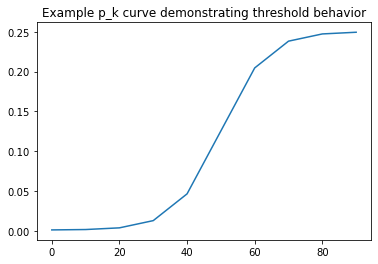

In [23]:
x = [k for k in range(0, 100, 10)]
y = [p_k(k=k, k_0 = 50, p_lo=0.001, p_hi=0.25, g=0.15) for k in range(0, 100, 10)]

plt.title("Example p_k curve demonstrating threshold behavior")
plt.plot(x, y)

In [24]:
def complex_model(agents_df, news_df, first_n_hours, exposures_by_login, k_0, p_hi, g, q, s):
    
    periods = range(first_n_hours)
    
    infected_counts = []
    infected_times = np.array([0 for _ in range(len(agents_df))], dtype=int)
    agents = np.array([0 for _ in range(len(agents_df))], dtype=bool)
                       
    for time_pd in periods:
        
        probs = np.zeros(agents.size)
        
        for agent in range(agents.size):
            exposures = exposures_by_login.get((time_pd, agent))
            if exposures:
                
                agent_not_adopting_prob = 1
                for idx in range(1, len(exposures)):
                    
                    k_adptrs, exp_cum_k = exposures[idx]
                    _, exp_pre_k = exposures[idx-1]
                    exp_at_k = exp_cum_k - exp_pre_k
                    
                    agent_not_adopting_prob *= (1 - p_k(k_adptrs, k_0, p_hi=p_hi, g=g))**exp_at_k   
                    
                probs[agent] = 1 - agent_not_adopting_prob
          
        day = time_pd // 24 # floor division
        news_rate = news_df.at[day, "Articles"]
        probs = probs + s*q*news_rate
        probs = np.clip(probs, a_min=None, a_max=1.0)
        
        infections = np.random.binomial(
            n=1, 
            p=probs, 
            size=agents.size
        ).astype(bool)
        new_infected = np.logical_and(np.logical_not(agents), infections)
        infected_times = np.where(new_infected, time_pd, infected_times) # Where True, yield x, otherwise yield y.
        
        agents = np.logical_or(infections, agents)
        infected_counts.append(agents.sum())
        
    return infected_counts, infected_times

## Grid-Search

In [25]:
options_broadcast = {
    'q': [0.000001, 0.000005, 0.00001, 0.000015, 0.00002, 0.00005],
}
options_broadcast_thin = {
    'q': [0.00001, 0.000011, 0.000012, 0.000013, 0.000014, 0.000015],
}

options_simple = {
    'p': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.015],
    'q': [0.000013],
    's': [0.1, 0.3, 0.5, 0.7, 0.9],
}
options_simple_thin = {
    'p': [0.0001, 0.00025, 0.0004, 0.000625, 0.00085, 0.001],
    'q': [0.000013],
    's': [0.7, 0.75, 0.8, 0.85, 0.9],
}

options_complex = {
    'k_0': [5, 20, 50, 100, 200, 300],
    'p_hi': [0.05, 0.1, 0.2, 0.3, 0.5],
    'g': [0.15],      # range of roughly 50, 10% of median followers.
    'q': [0.000013],
    's': [0.1, 0.3, 0.5, 0.7, 0.9],
}

options_complex_thin = {
    'k_0': [200, 220, 240, 260, 280, 300],
    'p_hi': [0.30, 0.35, 0.4, 0.45, 0.50],
    'q': [0.000013],
    'g': [0.15],
    's': [0.5, 0.55, 0.6, 0.65, 0.7]
}

#### Find Best Broadcast Model

In [26]:
def test_broadcast_params(options, m_agents_df, first_n_hours = None):
    
    if not first_n_hours:
        first_n_hours = int(m_agents_df["adopted_hour"].max() + 1)

    broadcast_costs = []

    for q in options['q']:

        cost = least_squares(broadcast_model, m_agents_df, news_df, first_n_hours, q = q)
        broadcast_costs.append(
            (q, cost)
        )
        
    out = pd.DataFrame.from_dict(broadcast_costs)
    out.columns = ["q", "cost"]
    return out

In [38]:
costs_broadcast_df = test_broadcast_params(options_broadcast, agents_df)
costs_broadcast_df.to_csv("sim_results/broadcast_costs_first_round.csv")
costs_broadcast_df.sort_values(by="cost")

,q,cost
3,0.000015,1.606248e+06
2,0.000010,5.339827e+06
4,0.000020,1.196721e+07
1,0.000005,5.084512e+07
5,0.000050,1.053369e+08
0,0.000001,1.799437e+08


In [39]:
costs_broadcast_thin_df = test_broadcast_params(options_broadcast_thin, agents_df)
costs_broadcast_thin_df.to_csv("sim_results/broadcast_costs_second_round.csv")
costs_broadcast_thin_df.sort_values(by="cost")

,q,cost
3,0.000013,4.351138e+05
4,0.000014,6.474173e+05
2,0.000012,9.339375e+05
5,0.000015,1.469730e+06
1,0.000011,2.688677e+06
0,0.000010,4.971224e+06


#### Find Best Simple Model

In [27]:
def test_simple_params(options, m_agents_df, m_exposures_by_login, first_n_hours = None):
    
    if not first_n_hours:
        first_n_hours = int(m_agents_df["adopted_hour"].max() + 1)
        
    simple_costs = []

    for q in options['q']:
        for s in options['s']:
            for p in options['p']:

                cost = least_squares(
                    simple_model, 
                    m_agents_df, 
                    news_df, 
                    first_n_hours,
                    exposures_by_login = m_exposures_by_login,
                    p=p, 
                    q=q, 
                    s=s                                       
                )
                simple_costs.append(
                    (p, q, s, cost)
                )
           
    out = pd.DataFrame.from_dict(simple_costs)
    out.columns = ["p", "q", "s", "cost"]
    return out

In [41]:
costs_simple_df = test_simple_params(options_simple, agents_df, exposures_by_login)
costs_simple_df.to_csv("sim_results/simple_costs_first_round.csv")
costs_simple_df.sort_values(by="cost").head()

,p,q,s,cost
24,0.0001,0.000013,0.9,7.694375e+05
19,0.0010,0.000013,0.7,1.234539e+06
25,0.0010,0.000013,0.9,1.251256e+06
14,0.0030,0.000013,0.5,1.668899e+06
20,0.0030,0.000013,0.7,2.686596e+06


In [42]:
costs_simple_thin_df = test_simple_params(options_simple_thin, agents_df, exposures_by_login)
costs_simple_thin_df.to_csv("sim_results/simple_costs_second_round.csv")
costs_simple_thin_df.sort_values(by="cost")

,p,q,s,cost
26,0.000400,0.000013,0.90,4.275207e+05
21,0.000625,0.000013,0.85,4.820951e+05
16,0.000850,0.000013,0.80,5.148330e+05
27,0.000625,0.000013,0.90,5.366781e+05
25,0.000250,0.000013,0.90,5.580601e+05
22,0.000850,0.000013,0.85,5.710729e+05
20,0.000400,0.000013,0.85,5.767760e+05
17,0.001000,0.000013,0.80,6.188520e+05
11,0.001000,0.000013,0.75,6.942738e+05
15,0.000625,0.000013,0.80,7.342142e+05


#### Find Best Complex Model

In [28]:
def test_complex_params(options, m_agents_df, m_exposures_by_login, first_n_hours = None):
    '''
    Allow variable agents, exposures by login to filter based on time.
    '''
    
    if not first_n_hours:
        first_n_hours = int(m_agents_df["adopted_hour"].max() + 1)

    complex_costs = []

    for k_0 in options['k_0']:
        for p_hi in options['p_hi']:
            for g in options['g']:
                for q in options['q']:
                    for s in options['s']:

                        cost = least_squares(
                            complex_model, 
                            m_agents_df, 
                            news_df, 
                            first_n_hours,
                            exposures_by_login = m_exposures_by_login,
                            k_0 = k_0,
                            p_hi = p_hi,
                            g = g,
                            q = q, 
                            s = s,                                                        
                        )
                        complex_costs.append(
                            (k_0, p_hi, g, q, s, cost)
                        )
    
    out = pd.DataFrame.from_dict(complex_costs)
    out.columns = ["k_0", "p_hi", "g", "q", "s", "cost"]
    return out

In [44]:
costs_complex_df = test_complex_params(options_complex, agents_df, exposures_by_login)
costs_complex_df.to_csv("sim_results/complex_costs_first_round.csv")
costs_complex_df.sort_values(by="cost").head(10)

,k_0,p_hi,g,q,s,cost
118,200,0.30,0.15,0.000013,0.7,661335.018779
123,200,0.50,0.15,0.000013,0.7,664205.131455
108,200,0.10,0.15,0.000013,0.7,699676.549296
113,200,0.20,0.15,0.000013,0.7,716500.079812
103,200,0.05,0.15,0.000013,0.7,723999.638498
138,300,0.20,0.15,0.000013,0.7,880902.140845
133,300,0.10,0.15,0.000013,0.7,887857.718310
143,300,0.30,0.15,0.000013,0.7,907456.089202
148,300,0.50,0.15,0.000013,0.7,916234.633803
128,300,0.05,0.15,0.000013,0.7,927153.624413


In [45]:
costs_complex_thin_df = test_complex_params(options_complex_thin, agents_df, exposures_by_login)
costs_complex_thin_df.to_csv("sim_results/complex_costs_second_round.csv")
costs_complex_thin_df.sort_values(by="cost").head(20)

,k_0,p_hi,g,q,s,cost
19,200,0.45,0.15,0.000013,0.7,637557.751174
39,220,0.40,0.15,0.000013,0.7,664774.075117
4,200,0.30,0.15,0.000013,0.7,673846.967136
14,200,0.40,0.15,0.000013,0.7,676734.164319
24,200,0.50,0.15,0.000013,0.7,679174.323944
29,220,0.30,0.15,0.000013,0.7,680460.225352
49,220,0.50,0.15,0.000013,0.7,707085.028169
9,200,0.35,0.15,0.000013,0.7,716478.258216
99,260,0.50,0.15,0.000013,0.7,730838.873239
44,220,0.45,0.15,0.000013,0.7,738096.690141


### View Best Options

In [38]:
costs_simple_thin_df = pd.read_csv("sim_results/simple_costs_second_round.csv")
costs_complex_thin_df = pd.read_csv("sim_results/complex_costs_second_round.csv")
costs_broadcast_thin_df = pd.read_csv("sim_results/broadcast_costs_second_round.csv")

In [40]:
best_ref = costs_broadcast_thin_df.sort_values(by="cost").head(1)
best_ref.reset_index(inplace=True)
best_ref

,index,Unnamed: 0,q,cost
0,3,3,0.000013,435113.835681


477310.84245283017

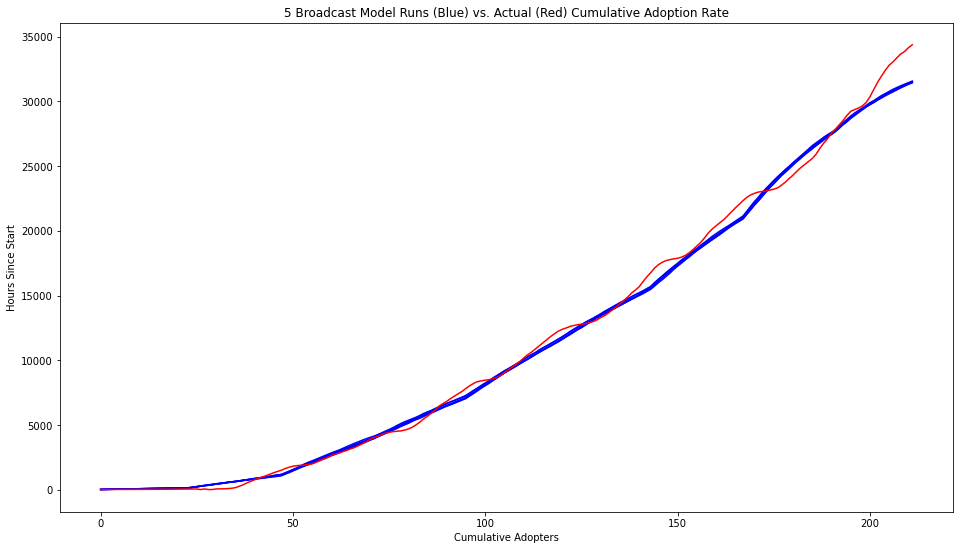

In [50]:
plt.figure(figsize=(16, 9))
plt.title("5 Broadcast Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
plt.xlabel("Cumulative Adopters")
plt.ylabel("Hours Since Start")

true_counts = get_cum_adopts(agents_df)[1:]
costs = []
for i in range(5):
    
    pred_counts, pred_times = broadcast_model(
        agents_df, 
        news_df, 
        first_n_hours = 212,
        q = best_ref.loc[0, "q"],
    )
    plt.plot(range(len(pred_counts)), pred_counts, color="blue")
    
    cost = np.sum(
        np.subtract(pred_counts, true_counts)**2
    )/len(true_counts)
    costs.append(cost)
    
plt.plot(range(len(true_counts)), true_counts, color="red")  
np.mean(costs)

In [39]:
best_simple = costs_simple_thin_df.sort_values(by="cost").head(1)
best_simple.reset_index(inplace=True)
best_simple

,index,Unnamed: 0,p,q,s,cost
0,26,26,0.0004,0.000013,0.9,427520.70892


397871.79154929577

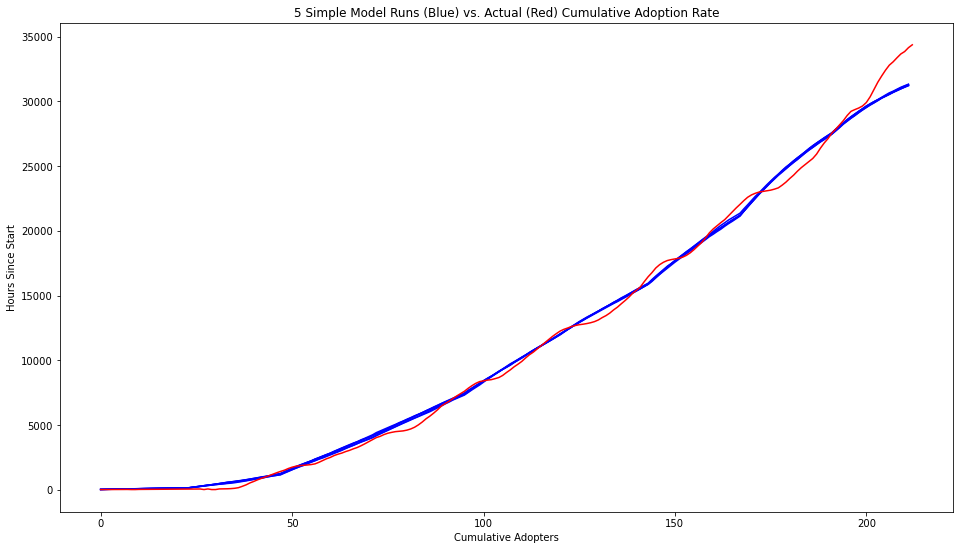

In [52]:
plt.figure(figsize=(16, 9))
plt.title("5 Simple Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
plt.xlabel("Cumulative Adopters")
plt.ylabel("Hours Since Start")

costs = []
true_counts = get_cum_adopts(agents_df)

for i in range(5):
    
    logins = generate_logins(agents_df)
    exposures_by_login = get_exposures_by_login(agents_df, logins)
    
    pred_counts, pred_times = simple_model(
        agents_df, 
        news_df, 
        first_n_hours = 212,
        exposures_by_login = exposures_by_login,
        p = best_simple.loc[0, "p"],
        q=0.000013,
        s= best_simple.loc[0, "s"],
    )
    plt.plot(range(len(pred_counts)), pred_counts, color="blue")
    
    cost = np.sum(
        np.subtract(pred_counts[:212], true_counts[:212])**2
    )/len(true_counts)
    costs.append(cost)
    
plt.plot(range(len(true_counts)), true_counts, color="red")  
np.mean(costs)

In [41]:
best_complex = costs_complex_thin_df.sort_values(by="cost").head(1)
best_complex.reset_index(inplace=True)
best_complex

,index,Unnamed: 0,k_0,p_hi,g,q,s,cost
0,19,19,200,0.45,0.15,0.000013,0.7,637557.751174


610377.2131455399

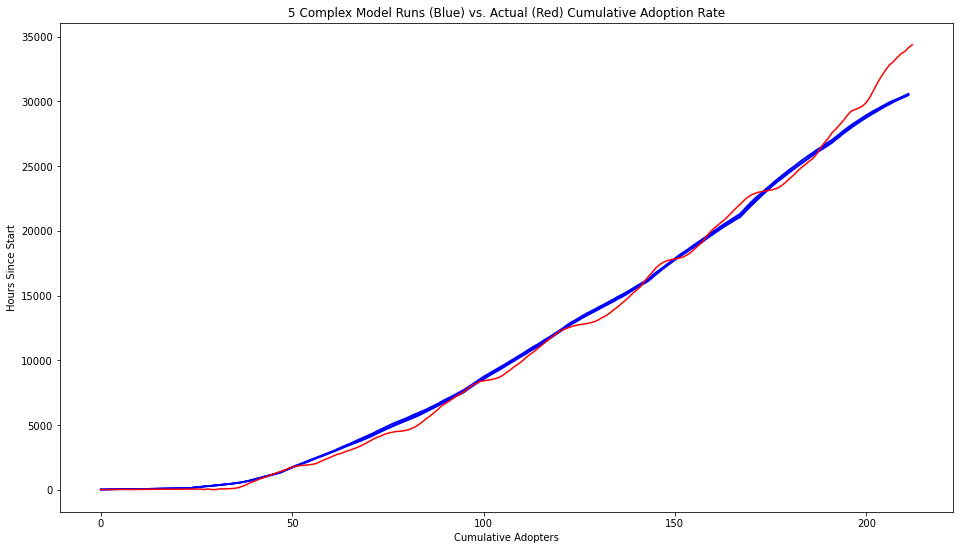

In [54]:
plt.figure(figsize=(16, 9))
plt.title("5 Complex Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
plt.xlabel("Cumulative Adopters")
plt.ylabel("Hours Since Start")

costs = []
true_counts = get_cum_adopts(agents_df)

for i in range(5):

    logins = generate_logins(agents_df)
    exposures_by_login = get_exposures_by_login(agents_df, logins)
    
    pred_counts, pred_times = complex_model(
        agents_df, 
        news_df, 
        first_n_hours = 212,
        exposures_by_login = exposures_by_login,
        k_0 = best_complex.loc[0, "k_0"],
        p_hi = best_complex.loc[0, "p_hi"],
        g = 0.15,
        q=0.000013,
        s= best_complex.loc[0, "s"],
    )
    plt.plot(range(len(pred_counts)), pred_counts, color="blue")
    
    cost = np.sum(
        np.subtract(pred_counts[:212], true_counts[:212])**2
    )/len(true_counts)
    costs.append(cost)
    
plt.plot(range(len(true_counts)), true_counts, color="red") 
np.mean(costs)

## Examining the First 48 Hours

In [29]:
options_broadcast_thin_48 = {
    'q': [0.000010, 0.000011, 0.000012, 0.000013, 0.000014, 0.000015],
}

options_simple_thin_48 = {
    'p': [0.003, 0.0035, 0.004, 0.0045, 0.005],
    'q': [0.000013],
    's': [0.1, 0.15, 0.2, 0.25, 0.3],
}

options_complex_thin_48 = {
    'k_0': [50, 67.5, 75, 82.5, 100],
    'p_hi': [0.05, 0.0625, 0.075, 0.0825, 0.1],
    'q': [0.000013],
    'g': [0.15],
    's': [0.1, 0.15, 0.2, 0.25, 0.3]
}

In [56]:
costs_broadcast_48_df = test_broadcast_params(options_broadcast, agents_df, first_n_hours = 48)
costs_broadcast_48_df.to_csv("sim_results/broadcast_costs_48_first_round.csv")
costs_broadcast_48_df.sort_values(by="cost")

,q,cost
2,0.000010,9604.328638
1,0.000005,19598.732394
3,0.000015,21877.051643
4,0.000020,37346.032864
0,0.000001,37770.112676
5,0.000050,555141.323944


In [57]:
costs_broadcast_48_thin_df = test_broadcast_params(options_broadcast_thin_48, agents_df, first_n_hours = 48)
costs_broadcast_48_thin_df.to_csv("sim_results/broadcast_costs_48_second_round.csv")
costs_broadcast_48_thin_df.sort_values(by="cost")

,q,cost
0,0.000010,9737.389671
1,0.000011,10656.460094
2,0.000012,12561.835681
3,0.000013,14742.225352
4,0.000014,14840.140845
5,0.000015,16882.957746


In [58]:
costs_simple_48_df = test_simple_params(options_simple, agents_df, exposures_by_login, first_n_hours = 48)
costs_simple_48_df.to_csv("sim_results/simple_costs_48_first_round.csv")
costs_simple_48_df.sort_values(by="cost").head(20)

,p,q,s,cost
3,0.0050,0.000013,0.1,541.070423
8,0.0030,0.000013,0.3,1250.014085
2,0.0030,0.000013,0.1,2542.615023
14,0.0030,0.000013,0.5,3067.408451
9,0.0050,0.000013,0.3,4970.225352
19,0.0010,0.000013,0.7,5737.568075
13,0.0010,0.000013,0.5,5804.093897
7,0.0010,0.000013,0.3,8735.192488
18,0.0001,0.000013,0.7,9386.267606
24,0.0001,0.000013,0.9,10327.882629


In [59]:
costs_simple_48_thin_df = test_simple_params(options_simple_thin_48, agents_df, exposures_by_login, first_n_hours = 48)
costs_simple_48_thin_df.to_csv("sim_results/simple_costs_48_second_round.csv")
costs_simple_48_thin_df.sort_values(by="cost").head(20)

,p,q,s,cost
3,0.0045,0.000013,0.10,265.239437
2,0.0040,0.000013,0.10,389.699531
7,0.0040,0.000013,0.15,455.657277
8,0.0045,0.000013,0.15,593.497653
12,0.0040,0.000013,0.20,620.084507
4,0.0050,0.000013,0.10,728.197183
6,0.0035,0.000013,0.15,776.107981
16,0.0035,0.000013,0.25,907.356808
11,0.0035,0.000013,0.20,918.004695
1,0.0035,0.000013,0.10,925.262911


In [60]:
costs_complex_48_df = test_complex_params(options_complex, agents_df, exposures_by_login, first_n_hours = 48)
costs_complex_48_df.to_csv("sim_results/complex_costs_48_first_round.csv")
costs_complex_48_df.sort_values(by="cost").head(20)

,k_0,p_hi,g,q,s,cost
55,50,0.10,0.15,0.000013,0.1,341.413146
50,50,0.05,0.15,0.000013,0.1,686.215962
51,50,0.05,0.15,0.000013,0.3,1535.826291
60,50,0.20,0.15,0.000013,0.1,1744.812207
91,100,0.30,0.15,0.000013,0.3,2068.732394
96,100,0.50,0.15,0.000013,0.3,2116.507042
87,100,0.20,0.15,0.000013,0.5,2169.460094
92,100,0.30,0.15,0.000013,0.5,2353.652582
82,100,0.10,0.15,0.000013,0.5,2375.685446
86,100,0.20,0.15,0.000013,0.3,2506.544601


In [30]:
costs_complex_48_thin_df = test_complex_params(options_complex, agents_df, exposures_by_login, first_n_hours = 48)
costs_complex_48_thin_df.to_csv("sim_results/complex_costs_48_second_round.csv")
costs_complex_48_thin_df.sort_values(by="cost").head(20)

,k_0,p_hi,g,q,s,cost
55,50,0.10,0.15,0.000013,0.1,585.915493
50,50,0.05,0.15,0.000013,0.1,615.647887
51,50,0.05,0.15,0.000013,0.3,1196.422535
91,100,0.30,0.15,0.000013,0.3,1691.995305
96,100,0.50,0.15,0.000013,0.3,1845.887324
60,50,0.20,0.15,0.000013,0.1,1932.234742
77,100,0.05,0.15,0.000013,0.5,2400.737089
86,100,0.20,0.15,0.000013,0.3,2611.164319
97,100,0.50,0.15,0.000013,0.5,2671.295775
81,100,0.10,0.15,0.000013,0.3,2837.427230


### View Best Options for 48

In [31]:
def view_best_ref(model_params, m_agents_df, first_n_hours=212):
    
    plt.figure(figsize=(16, 9))
    plt.title("5 Broadcast Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
    plt.xlabel("Cumulative Adopters")
    plt.ylabel("Hours Since Start")

    true_counts = get_cum_adopts(agents_df)[1:first_n_hours+1]
    costs = []
    
    for i in range(5):

        pred_counts, pred_times = broadcast_model(
            agents_df, 
            news_df, 
            first_n_hours = first_n_hours,
            q = model_params["q"],
        )
        plt.plot(range(len(pred_counts)), pred_counts, color="blue")

        cost = (
            np.sum(
                np.subtract(pred_counts, true_counts)**2
            ) / first_n_hours
        )
        costs.append(cost)

    plt.plot(range(len(true_counts)), true_counts, color="red")  
    print("Mean (over 5) Cost:", np.mean(costs))

In [33]:
def view_best_simple(model_params, m_agents_df, first_n_hours=212):
    
    plt.figure(figsize=(16, 9))
    plt.title("5 Simple Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
    plt.xlabel("Cumultive Adopters")
    plt.ylabel("Hours Since Start")

    costs = []
    true_counts = get_cum_adopts(agents_df)[1:first_n_hours+1]

    for i in range(5):

        logins = generate_logins(m_agents_df)
        exposures_by_login = get_exposures_by_login(m_agents_df, logins)

        pred_counts, pred_times = simple_model(
            m_agents_df, 
            news_df, 
            first_n_hours = first_n_hours,
            exposures_by_login = exposures_by_login,
            p = model_params["p"],
            q = model_params["q"],
            s = model_params["s"],
        )
        plt.plot(range(first_n_hours), pred_counts, color="blue")

        cost = (
            np.sum(
                np.subtract(pred_counts, true_counts)**2
            ) / first_n_hours
        )
        costs.append(cost)

    plt.plot(range(first_n_hours), true_counts, color="red")  
    print("Mean (over 5) Cost:", np.mean(costs))


In [34]:
def view_best_complex(model_params, m_agents_df, first_n_hours=212):
    
    plt.figure(figsize=(16, 9))
    plt.title("5 Complex Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
    plt.xlabel("Cumultive Adopters")
    plt.ylabel("Hours Since Start")

    costs = []
    true_counts = get_cum_adopts(agents_df)[1:49]

    for i in range(5):

        logins = generate_logins(agents_df)
        exposures_by_login = get_exposures_by_login(agents_df, logins)

        pred_counts, pred_times = complex_model(
            agents_df, 
            news_df, 
            first_n_hours = first_n_hours,
            exposures_by_login = exposures_by_login,
            k_0 = model_params["k_0"],
            p_hi = model_params["p_hi"],
            g = model_params["g"],
            q= model_params["q"],
            s= model_params["s"],
        )
        plt.plot(range(first_n_hours), pred_counts, color="blue")

        cost = (
            np.sum(
                np.subtract(pred_counts, true_counts)**2
            )/len(true_counts)
        )
        costs.append(cost)

    plt.plot(range(len(true_counts)), true_counts, color="red") 
    print("Mean (over 5) Cost:", np.mean(costs))

In [43]:
costs_simple_thin_df = pd.read_csv("sim_results/simple_costs_48_second_round.csv")
costs_complex_thin_df = pd.read_csv("sim_results/complex_costs_48_second_round.csv")
costs_broadcast_thin_df = pd.read_csv("sim_results/broadcast_costs_48_second_round.csv")

In [44]:
best_ref = costs_broadcast_thin_df.sort_values(by="cost").head(1)
best_ref.reset_index(inplace=True)
best_ref

,index,Unnamed: 0,q,cost
0,0,0,0.00001,9737.389671


In [45]:
best_simple = costs_simple_thin_df.sort_values(by="cost").head(1)
best_simple.reset_index(inplace=True)
best_simple

,index,Unnamed: 0,p,q,s,cost
0,3,3,0.0045,0.000013,0.1,265.239437


3978.0666666666666

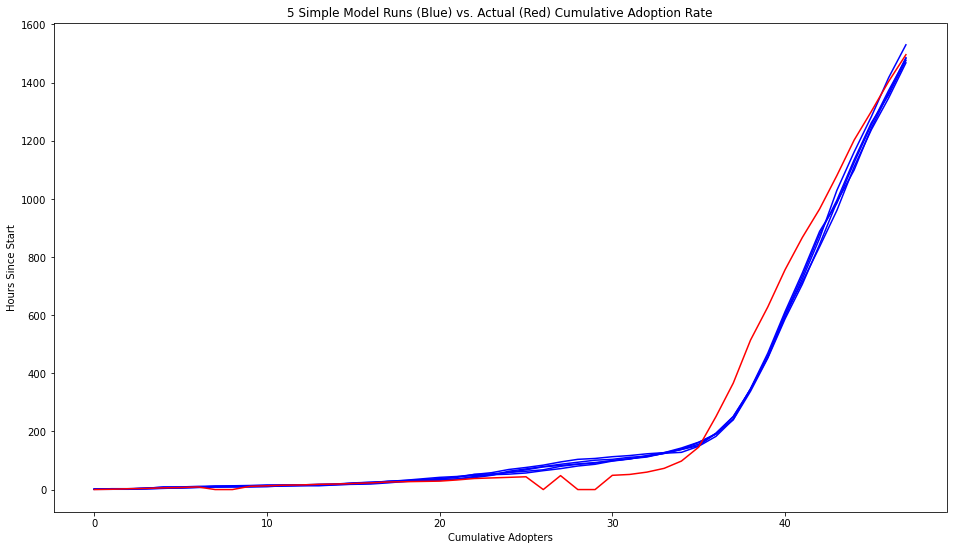

In [46]:
plt.figure(figsize=(16, 9))
plt.title("5 Simple Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
plt.xlabel("Cumulative Adopters")
plt.ylabel("Hours Since Start")

costs = []
true_counts = get_cum_adopts(agents_df)[1:49]

for i in range(5):
    
    logins = generate_logins(agents_df)
    exposures_by_login = get_exposures_by_login(agents_df, logins)
    
    pred_counts, pred_times = simple_model(
        agents_df, 
        news_df, 
        first_n_hours = 48,
        exposures_by_login = exposures_by_login,
        p = best_simple.loc[0, "p"],
        q=0.000013,
        s= best_simple.loc[0, "s"],
    )
    plt.plot(range(len(pred_counts)), pred_counts, color="blue")
    
    cost = np.sum(
        np.subtract(pred_counts, true_counts)**2
    )/len(true_counts)
    costs.append(cost)
    
plt.plot(range(len(true_counts)), true_counts, color="red")  
np.mean(costs)

In [47]:
best_complex = costs_complex_thin_df.sort_values(by="cost").head(1)
best_complex.reset_index(inplace=True)
best_complex

,index,Unnamed: 0,k_0,p_hi,g,q,s,cost
0,55,55,50,0.1,0.15,0.000013,0.1,585.915493


4995.750000000001

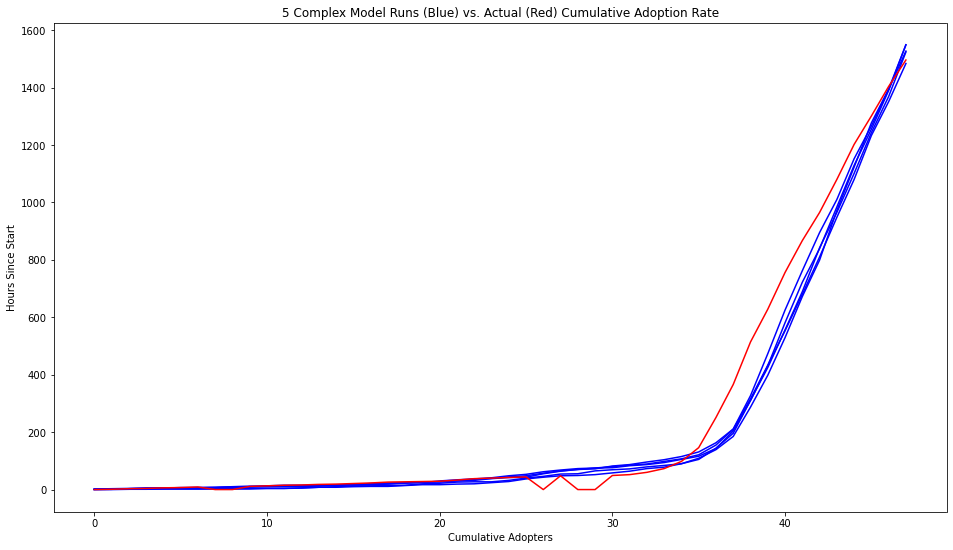

In [48]:
plt.figure(figsize=(16, 9))
plt.title("5 Complex Model Runs (Blue) vs. Actual (Red) Cumulative Adoption Rate")
plt.xlabel("Cumulative Adopters")
plt.ylabel("Hours Since Start")

costs = []
true_counts = get_cum_adopts(agents_df)[1:49]

for i in range(5):

    logins = generate_logins(agents_df)
    exposures_by_login = get_exposures_by_login(agents_df, logins)
    
    pred_counts, pred_times = complex_model(
        agents_df, 
        news_df, 
        first_n_hours = 48,
        exposures_by_login = exposures_by_login,
        k_0 = best_complex.loc[0, "k_0"],
        p_hi = best_complex.loc[0, "p_hi"],
        g = 0.15,
        q=0.000013,
        s= best_complex.loc[0, "s"],
    )
    plt.plot(range(len(pred_counts)), pred_counts, color="blue")
    
    cost = np.sum(
        np.subtract(pred_counts, true_counts)**2
    )/len(true_counts)
    costs.append(cost)
    
plt.plot(range(len(true_counts)), true_counts, color="red") 
np.mean(costs)

### Examine First 48 by Cluster

In [ ]:

costs_simple_48_df
costs_complex_48_df

In [49]:
def thin_broadcast_search(costs_broadcast_df):
    
    
    costs_broadcast_df = costs_broadcast_df.sort_values(by="cost")    
    best_qs = costs_broadcast_df["q"].drop_duplicates().head(2)
    
    return {
        "q": np.linspace(start=best_qs.min(), stop=best_qs.max(), num=6) 
    }

In [50]:
def thin_simple_search(costs_simple_df):
    
    costs_simple_df = costs_simple_df.sort_values(by="cost")  
    q = costs_simple_df.loc[0, "q"]
    
    best_ps = costs_simple_df["p"].drop_duplicates().head(2)
    best_ss = costs_simple_df["s"].drop_duplicates().head(2)
    
    return {
        "q": [q],
        "p": np.linspace(start=best_ps.min(), stop=best_ps.max(), num=6),
        "s": np.linspace(start=best_ss.min(), stop=best_ss.max(), num=5) 
    }    

In [51]:
def thin_complex_search(costs_complex_df):
    
    costs_complex_df = costs_complex_df.sort_values(by="cost")
    
    q = costs_complex_df.loc[0, "q"]
    g = costs_complex_df.loc[0, "g"]
    
    best_k_0s = costs_complex_df["k_0"].drop_duplicates().head(2)
    best_p_his = costs_complex_df["p_hi"].drop_duplicates().head(2)
    best_ss = costs_complex_df["s"].drop_duplicates().head(2)
    
    return {
        "q": [q],
        "g": [g],
        "k_0": np.linspace(start=best_k_0s.min(), stop=best_k_0s.max(), num=6),
        "p_hi": np.linspace(start=best_p_his.min(), stop=best_p_his.max(), num=6),
        "s": np.linspace(start=best_ss.min(), stop=best_ss.max(), num=5) 
    }    

In [54]:
def find_best_params(m_agents_df, first_n_hours):
    
    options_broadcast = {
        'q': [0.000001, 0.000005, 0.00001, 0.000015, 0.00002, 0.00005],
    }
    
    m_agents_df.reset_index(inplace=True)
    m_logins = generate_logins(m_agents_df)
    m_exposures_by_login = get_exposures_by_login(m_agents_df, m_logins)
        
    costs_broadcast_df = test_broadcast_params(
        options_broadcast, 
        m_agents_df, 
        first_n_hours = first_n_hours
    )    
    costs_broadcast_thin_df = test_broadcast_params(
        thin_broadcast_search(costs_broadcast_df),
        m_agents_df,
        first_n_hours = first_n_hours
    )
    costs_broadcast_thin_df.sort_values(by="cost", inplace=True)
    print(costs_broadcast_thin_df.head(1))
    
    # To return:
    best_broadcast = {
        'q': costs_broadcast_thin_df["q"][0]
    }
    
    options_simple = {
        'p': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.015],
        's': [0.1, 0.3, 0.5, 0.7, 0.9],
        'q': [best_broadcast['q']]
    }
    
    costs_simple_df = test_simple_params(
        options_simple, 
        m_agents_df, 
        m_exposures_by_login, 
        first_n_hours = first_n_hours
    )
    costs_simple_thin_df = test_simple_params(
        thin_simple_search(costs_simple_df),
        m_agents_df,
        m_exposures_by_login,
        first_n_hours = first_n_hours
    ) 
    costs_simple_thin_df.sort_values(by="cost", inplace=True)
    print(costs_simple_thin_df.head(1))
    
    # To return:
    best_simple = {
        'p': costs_simple_thin_df["p"][0],
        'q': costs_simple_thin_df["q"][0],
        's': costs_simple_thin_df["s"][0]
    }
    
    options_complex = {
        'k_0': [5, 20, 50, 100, 200, 300],
        'p_hi': [0.05, 0.1, 0.2, 0.3, 0.5],
        'g': [0.15],      # range of roughly 50, 10% of median followers.
        's': [0.1, 0.3, 0.5, 0.7, 0.9],
        'q': [best_broadcast['q']]
    }

    costs_complex_df = test_complex_params(
        options_complex, 
        m_agents_df, 
        m_exposures_by_login, 
        first_n_hours = first_n_hours
    )
    costs_complex_thin_df = test_complex_params(
        thin_complex_search(costs_complex_df),
        m_agents_df,
        m_exposures_by_login,
        first_n_hours = first_n_hours
    )    
    
    print(costs_complex_thin_df.sort_values(by="cost").head(1))
    print("_______________")
    
    # To return:
    best_complex = {
        'k_0': costs_complex_thin_df["k_0"][0],
        'p_hi': costs_complex_thin_df["p_hi"][0],
        'g': costs_complex_thin_df["g"][0],
        'q': costs_complex_thin_df["q"][0],        
        's': costs_complex_thin_df["s"][0]
    }
    
    return best_broadcast, best_simple, best_complex

In [55]:
for cluster_label, cl_agents_df in agents_df.groupby("cluster_label"):
    
    best_broadcast, best_simple, best_complex = find_best_params(cl_agents_df, 48)
    

          q       cost
2  0.000007  66.037559
        p         q    s      cost
4  0.0026  0.000005  0.1  2.192488
      k_0  p_hi     g         q    s      cost
79  140.0  0.38  0.15  0.000005  0.5  3.661972
_______________
          q        cost
3  0.000013  312.892019
         p        q    s      cost
16  0.0046  0.00001  0.2  9.122066
    k_0  p_hi     g        q     s       cost
6  50.0  0.22  0.15  0.00001  0.15  14.431925
_______________
          q        cost
4  0.000009  141.699531
        p         q    s      cost
12  0.003  0.000005  0.4  8.103286
     k_0  p_hi     g         q    s      cost
75  70.0  0.32  0.15  0.000005  0.1  3.892019
_______________
          q        cost
2  0.000012  925.079812
        p        q     s       cost
8  0.0038  0.00001  0.15  50.643192
    k_0  p_hi     g        q     s       cost
6  50.0  0.06  0.15  0.00001  0.15  36.507042
_______________
          q       cost
1  0.000006  94.389671
        p         q    s      cost
8  0.0038  0.

### View Best Options

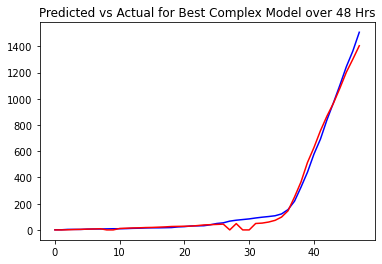

In [58]:
options = [50, 0.1, 0.15, 0.00013, 0.1]

for i in range(1):
    pred_counts, pred_times = complex_model(
        agents_df, 
        news_df, 
        first_n_hours = 48,
        exposures_by_login = exposures_by_login,
        k_0 = options[0],
        p_hi = options[1],
        g = 0.15,
        q=0.000013,
        s=options[4],
    )
    plt.plot(range(len(pred_counts)), pred_counts, color="blue")
    
true_counts = get_cum_adopts(agents_df)[:48]
plt.title("Predicted vs Actual for Best Complex Model over 48 Hrs")
plt.plot(range(len(true_counts)), true_counts, color="red")

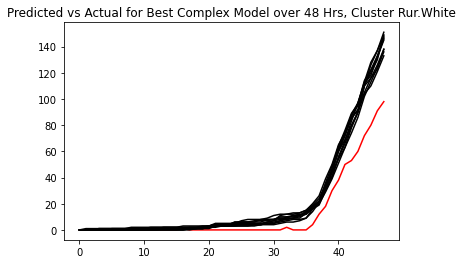

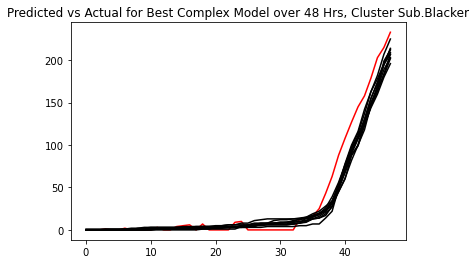

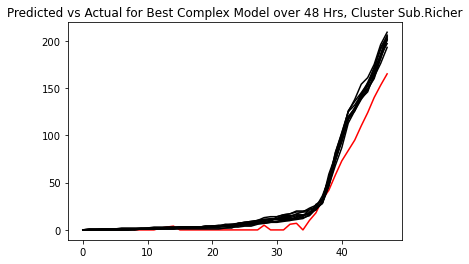

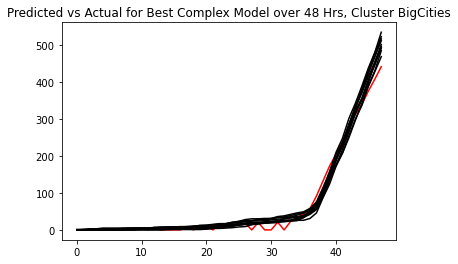

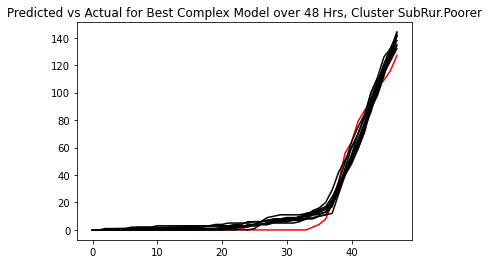

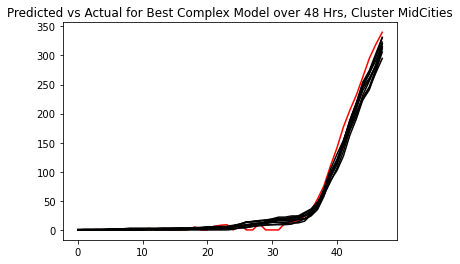

In [59]:
i = 0
options = [50, 0.1, 0.15, 0.00013, 0.1]


for cluster_label, cl_agents_df in agents_df.groupby("cluster_label"):
    
    cl_agents_df.reset_index(inplace=True)
    
    cl_logins = generate_logins(cl_agents_df)
    cl_exposures_by_login = get_exposures_by_login(cl_agents_df, cl_logins)
    
    true_counts = get_cum_adopts(cl_agents_df)
    plt.plot(range(48), true_counts[:48], color="red")
    
    for i in range(10):
        
        pred_counts, pred_times = complex_model(
            cl_agents_df, 
            news_df, 
            first_n_hours = 48,
            exposures_by_login = cl_exposures_by_login,
            k_0 = options[0],
            p_hi = options[1],
            g = 0.15,
            q=0.000013,
            s=options[4],
        )
        plt.title(f"Predicted vs Actual for Best Complex Model over 48 Hrs, Cluster {labels[cluster_label]}")
        plt.plot(range(len(pred_counts)), pred_counts, color="black")
        
    i += 1
    plt.show()
    